# Data science challenge

We are given the following dataset:

In [1]:
import pandas
df = pandas.read_csv("aft100k.csv")
print(df.head(10))

   creative_id user_operating_system       user_device  \
0       113521               Android             Phone   
1       115340               Windows  PersonalComputer   
2       113582               Android             Phone   
3        97385               Windows  PersonalComputer   
4       114821               Windows  PersonalComputer   
5       113065               Android            Tablet   
6       111414                   iOS             Phone   
7       111414                   iOS             Phone   
8       112705               Windows  PersonalComputer   
9       113176                 macOS  PersonalComputer   

   average_seconds_played      cost  revenue  
0                     NaN  0.010128      0.0  
1                0.000000  0.005937      0.0  
2                7.142857  0.004398      0.0  
3                     NaN  0.006157      0.0  
4                     NaN  0.001994      0.0  
5                     NaN  0.003781      0.0  
6               17.000000  0.002

- creative_id: A unique identifier of the video that has been displayed to the user
- user_operating_system: The user Operating System (OS)
- user_device: The user device type
- average_seconds_played: The average number of seconds the user usually watches our videos (only if we already know the user, based on the user history)
- cost: The cost we had to pay to display the video
- revenue: The revenue generated by this video when it has been watched


## Preliminary questions

####  1) The margin being defined as (revenue - cost) / revenue, what is our global margin based on this log?

In [2]:
print("Are there null revenues? {}".format(df["revenue"].isnull().values.any()))
print("Are there null costs? {}".format(df["cost"].isnull().values.any()))

Are there null revenues? False
Are there null costs? False


In [3]:
revs = df["revenue"].sum()
costs = df["cost"].sum()
margin = (revs-costs)/revs
print("Global margin is {0:.4f}, or {1:.2f}%".format(margin, margin*100))

Global margin is 0.2719, or 27.19%


#### 2) Can you think of other interesting metrics to optimize

Metrics to optimize:

1) Profits - No explanation needed.

2) Profits per device - We want to make sure all devices are profitable.

3) Profits per OS - We want to make sure all OSs are profitable.

4) Profits per video - We want to make sure all ads are profitable.

I would also like to understand why sometimes it takes more seconds than others to get the money - some of them don't make us any money in 30 seconds, some of them do in 10 seconds. I guess it is very possible that we are losing money in some type of ads. Maybe we should only display them in certain platforms where people is willing to spend more time watching ads - and this is a metric we could get from our csv, the number of seconds per device.

Moreover, it may be important for our clients two traditional metrics that don't appear in the csv: Click-through rate (CTR) and Conversion rate.



#### 3) What are the most profitable Operating Systems?

In [4]:
df_agg = df[['user_operating_system','cost', 'revenue']].groupby(
    ['user_operating_system']).sum()
series_profits = df_agg["revenue"]-df_agg["cost"]
print("Most profitable OSs:")
display(series_profits.sort_values(ascending=False))

Most profitable OSs:


user_operating_system
iOS              115.521775
Windows           65.873808
Android           27.279364
OS X               1.707775
Chrome OS          0.428130
Linux              0.372922
macOS              0.248021
Fire OS            0.142575
unknown            0.093995
BlackBerry OS      0.077391
BSD                0.040430
RIM OS            -0.005229
dtype: float64

The only real profitability comes from iOS, Windows and Android - anything else is barely profitable.

## Machine learning questions

#### How would you use this historical data to predict the event 'we benefit from a revenue' (i.e. revenue > 0) in a dataset where the revenue is not known yet?

#### Compute the prediction accuracy of a well chosen algorithm and comment the results. Do not hesitate to describe your methodology.

The problem at hand is a problem of supervised learning, in particular, it is a regression problem. We need to build a regressor from our dataset, using:

- Five features: *creative_id, user_operating_system, user_device, average_seconds_played, cost*. 
- A label: *revenues*.
- A regression algorithm: We have a dataset with 100 000 examples - that is pretty good to use some of the more complex algorithms like SVMs with kernels, or ensemble learning (random forests, adaboost). Neural networks could also be considered but, considering the scope of this work, it would take too long to train and optimize.


In order to validate our results, we will divide the dataset in 2, training set (80%) and test set (20%). Cross validation with several bags would be a better technique, but it would take longer.

Before doing this, and just in case our data has some hidden time sequentiality, let's shuffle the data.

In [5]:
from sklearn.utils import shuffle

df = shuffle(df)

df_train = df[:len(df)*4//5]
df_test = df[len(df)*4//5:]

##### Feature Generation

Feature generation is one of the most important processes in data science. A good result is accomplished thanks to domain expertise, proper data visualization, and trial and error - but this are in general too time consuming for the scope of the project.

Some interesting features we could investigate are:

1) Interactions: Interaction between the videos (creative_id) and the user device, or with the video and the operating system.

2) Binning: Create bins in case there is some skewness in a variable - for example, in our case, most of the distribution is close to the min.

##### Data cleaning:

The first problem we face is that the features user_device and average_seconds_played are not present in some examples of the data set - or, in pandas' jargon, they are NaNs.

In [6]:
feature_cols = ['creative_id', 'user_operating_system', 'user_device', 
                'average_seconds_played', 'cost']
label_col = ['revenue']

X_train = df_train.loc[:, feature_cols]
y_train = df_train[label_col]

print(X_train.isnull().sum())
print(y_train.isnull().sum())

creative_id                   0
user_operating_system         0
user_device                   7
average_seconds_played    49414
cost                          0
dtype: int64
revenue    0
dtype: int64


In the case of *user_device*, it is not a big problem (only 8 labels out of 100 000, we can discard 8 without any second thoughts). Also substituting the NaNs for the average or something similar is tricky since this is a categorical feature (i.e., a string) - we could use the most frequent value but, again, there is no need. 


In [7]:
y_train = y_train[-X_train["user_device"].isnull()]
X_train = X_train[-X_train["user_device"].isnull()]

In the case of *average_seconds_played*, the problem is different: more than half of the data does not contain a value for the feature. However in this case, this is a numerical feature which gives us two options:

1) Removal: We would end up with around 40% of the dataset. The impact of this could be huge, but at least we are not "tampering" the data.

2) Substituting the data with its average, mode or median. This looks more promising, and it will be our default approach.

It could be interesting to compare the performances of both options, but for the scope of this work lets limit ourselves to the second option.

In [8]:
import numpy as np
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_train["average_seconds_played"] = imp.fit_transform(X_train[["average_seconds_played"]])

##### Data visualization

Here is some very basic information from the dataset.

In [9]:
X_train.describe()

,creative_id,average_seconds_played,cost
count,79993.000000,79993.000000,79993.000000
mean,112154.661470,10.586241,0.005667
std,5251.163476,6.065971,0.003499
min,50634.000000,0.000000,0.000473
25%,112167.000000,10.586241,0.003308
50%,113521.000000,10.586241,0.004837
75%,114948.000000,10.586241,0.006616
max,115465.000000,175.000000,0.052878


Let's use some bar plots for the categorical features:

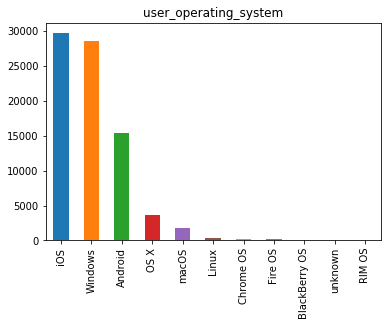

In [10]:
%matplotlib inline

X_train["user_operating_system"].value_counts().plot(kind='bar', title='user_operating_system')

We can see that our sample is mostly with iOS and Windows, and also some Android.

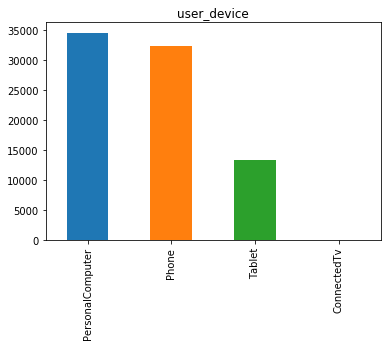

In [11]:
%matplotlib inline

X_train["user_device"].value_counts().plot(kind='bar', title='user_device')


We can appreciate that connected TVs are almost non existent.

For the numerical features, we have the following:

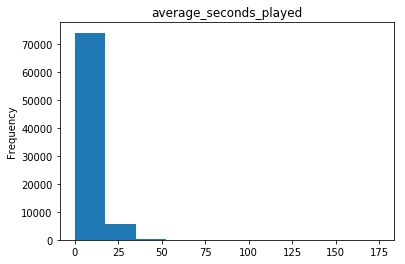

In [12]:
%matplotlib inline

X_train["average_seconds_played"].plot(kind='hist', title='average_seconds_played')

This calls for transformations. Let's try with a log transformation instead, with a logarithmic y-axis for better visualization. 

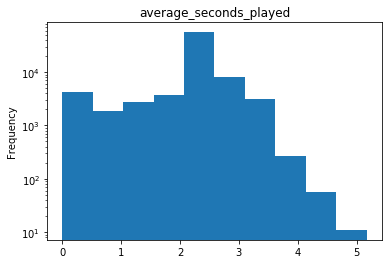

In [13]:
%matplotlib inline

X_train["average_seconds_played"] = pandas.Series(np.log1p(X_train["average_seconds_played"]))
X_train["average_seconds_played"].plot(kind='hist', logy=True, title='average_seconds_played')

This looks more like a normal distribution (actually, like a Laplace distribution due to its high kurtosis).

For the cost, this is what the histogram looks like:

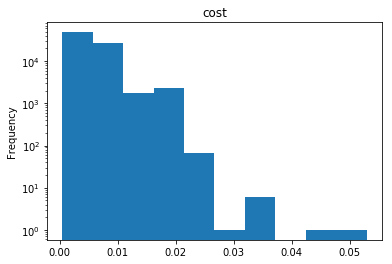

In [14]:
%matplotlib inline

X_train["cost"].plot(kind='hist', logy=True, title='cost')

Again, this calls for transformations. The log transformation does not work well, but the boxcox does.

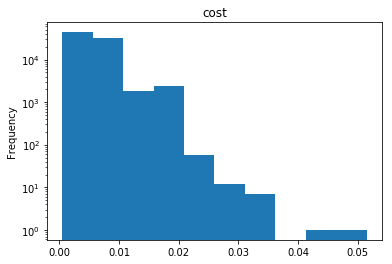

In [15]:
%matplotlib inline

pandas.Series(np.log1p(X_train["cost"])).plot(kind='hist', logy=True, title='cost')

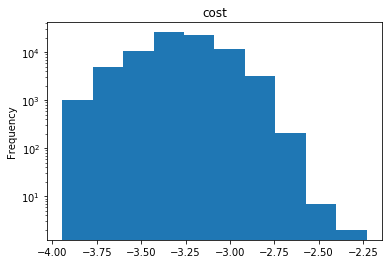

In [16]:
%matplotlib inline

from scipy.stats import boxcox
boxcox, _ = boxcox(X_train["cost"])
boxcox = pandas.Series(boxcox)

boxcox.plot(kind='hist', logy=True, title='cost')

In [17]:
X_train["cost"] = boxcox

##### Dealing with categorical features

We also need to encode the categorical features (*user_operating_system, user_device*) in order to feed them to the regressor algorithm. We could use CategoricalEncoder in order to do so, with "one hot" encoding being the preference here (since we don't want the ordering than the "ordinal" encoding brings).

`from sklearn import preprocessing`

`enc = preprocessing.CategoricalEncoder(encoding='onehot')`

However, it is not implemented yet in the version we are using so we will have to do it manually, and we will use the ordinal encoding - just because it is simpler, but as already stated, one hot encoding would make more sense in this particular case.

In [21]:
index = X_train["user_operating_system"].value_counts().axes[0].tolist()

X_train
print(index)

['iOS', 'Windows', 'Android', 'OS X', 'macOS', 'Linux', 'Chrome OS', 'Fire OS', 'BlackBerry OS', 'unknown', 'RIM OS']


In [18]:
raise Exception

Exception: 

In [ ]:
index = X_train["user_operating_system"].value_counts().axes[0]
encoder_os = {}
for idx, operating_system in enumerate(index.tolist()):
    encoder_os[operating_system] = idx

index = X_train["user_device"].value_counts().axes[0]
encoder_user_device = {}
for idx, device in enumerate(index.tolist()):
    encoder_user_device[device] = idx

def mapper(key, map_dict):
    '''Return the value of the encoding if found, -1 if not'''
    value = map_dict.get(key)
    if not value and value != 0:
        value = -1
    return value

def os_mapper(key):
    return mapper(key, encoder_os)

def user_device_mapper(key):
    return mapper(key, encoder_user_device)

print("encoder user_device {}".format(encoder_user_device))

In [ ]:
X_train["user_operating_system"] = X_train["user_operating_system"].apply(os_mapper)
X_train["user_device"] = X_train["user_device"].apply(user_device_mapper)

Regarding the feature 'creative_id', we have a problem, since it is numerical, but only in disguise - it is actually categorical, with the numerical values not meaning anything.

We could do several things:

1) We could use one hot encoding. This could provide us of a very good way of identifying the video. However, it also presents some problems:
    - there are too many variables - 926 in the training set.
    - what happens if we want to do this on other videos not in the list?
2) We could use this as a numerical feature. The problem is that there is no meaning in the number.

3) We could ignore the feature.

A rigorous approach would compare the three options, but to make it brief, let's ignore it.

In [ ]:
X_train = X_train.drop('creative_id', axis=1)

##### Data Normalization

Let's visualize the features: 

Now we will standardize the data, as it is important for some machine learning algorithms like SVMs.

In [ ]:
# Let's store the means and stds for the test data
means = X_train.mean()
std = X_train.std()

from sklearn import preprocessing

X_train[X_train.columns]=preprocessing.scale(X_train[X_train.columns])

display(X_train.head())

##### Feature Selection

Regarding feature selection, random forests produce a good indicator of which ones are best. In this case we will do it only for the 5 already existing variables but we should do it for the generated variables too.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

print(X_train.head())
print(y_train.head())
print(X_train.shape)
print(y_train.shape)
# Build a forest and compute the feature importances
forest = RandomForestRegressor(n_estimators=50)

forest.fit(X_train, y_train)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Build a forest and compute the feature importances
forest = RandomForestRegressor(n_estimators=50)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [ ]:

Feature scaling

3) Statistical Transformations: Same reason as above, we could try to reduce the skewness using transformations like log-


In [ ]:
from sklearn import svm

X = [[0, 0], [2, 2]]
y = [0.5, 2.5]
clf = svm.SVR()
clf.fit(X, y) 


clf.predict([[1, 1]])



Since we don't have another dataset, let's use the given dataset as a proxy for the new dataset - although, of course, we will use the revenue not as a feature but as a label. 

Use an SVR and ensemble regressors 
Feature selection? Evidently, no creative id

Cross Validation